In [1]:
import os
import sys
import glob
import tqdm
import math
import librosa
import librosa.display as display
import pickle

import numpy as np
np.random.seed(42)
import pandas as pd

import IPython.display as i_disn
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

from sklearn.model_selection import StratifiedShuffleSplit,train_test_split


In [2]:
# MAIN_DIR = "rabinnepal/github/Neural Network Project/"
MAIN_DIR = ".."
DATA_DIR = os.path.join(MAIN_DIR,"dataset")
FIG_DIR = os.path.join(MAIN_DIR,"Figures")
os.makedirs(FIG_DIR,exist_ok=True)

WORD_LABELS = ["ZERO","ONE","TWO","THREE","FOUR","FIVE","SIX","SEVEN","EIGHT","NINE"]
NUM_LABELS = [0,1,2,3,4,5,6,7,8,9]

SAMPLE_RATE = 44000 #Hz
LENGTH = 0.8 #seconds

## Data Extraction from Local Directory

In [3]:
files = glob.glob(DATA_DIR+"/**/*.wav",recursive=True)

In [4]:
print("Play a sample wavfile from the datset:")
i_disn.Audio(files[np.random.randint(len(files))])

Play a sample wavfile from the datset:


In [5]:
def fetch_data(**kwargs):
    audio = []
    labels = []
    for file in tqdm.tqdm(files,desc="Reading Data ... "):
        _audio, SR = librosa.load(file,sr=22050,dtype=np.float32)
        
        if(kwargs):
            length = kwargs["length"]
            min_allowed_len = kwargs["min"]
            max_allowed_len = kwargs["max"]
            if((len(_audio) > min_allowed_len) and (len(_audio) < max_allowed_len)):
                if(len(_audio)>length):
                    trim_front = math.floor((len(_audio) - length) / 2 )
                    trim_back = math.ceil((len(_audio) - length) / 2)
                    _audio = _audio[trim_front:-trim_back]
                elif(len(_audio)<length):
                    _audio = np.pad(_audio,(0,length-len(_audio)),constant_values=(0.0,0.0))
            else: 
                continue   
        audio.append(_audio)
        labels.append(os.path.split(file)[-1][0])
    return audio,SR,labels

In [6]:
audios, SR, labels = fetch_data()
audios = np.array(audios,dtype=object)
labels = np.array(labels,dtype=object)

Reading Data ... :   0%|          | 0/30000 [00:00<?, ?it/s]

Reading Data ... : 100%|██████████| 30000/30000 [00:33<00:00, 891.48it/s] 


In [7]:
print("Sampling Rate: ",SR)
# print("Labels: ",labels[:5])
print("Total Audio Files: ",len(audios))
print("Total Labels: ",len(labels))

Sampling Rate:  22050
Total Audio Files:  30000
Total Labels:  30000


## Data Analysis

In [25]:
os.getcwd()

'/Users/rabinnepal/gitHub/Neural Network Project/codes'

### See Speaker Accent Distribution

In [26]:
import json

# Specify the path to your text file containing JSON data
file_path = '/Users/rabinnepal/gitHub/Neural Network Project/dataset/audioMNIST_meta.txt'

# Read the content of the text file
with open(file_path, 'r') as file:
    json_data = json.load(file)

# Display the parsed JSON data
print(json_data)

{'01': {'accent': 'german', 'age': 30, 'gender': 'male', 'native speaker': 'no', 'origin': 'Europe, Germany, Wuerzburg', 'recordingdate': '17-06-22-11-04-28', 'recordingroom': 'Kino'}, '02': {'accent': 'German', 'age': '25', 'gender': 'male', 'native speaker': 'no', 'origin': 'Europe, Germany, Hamburg', 'recordingdate': '17-06-26-17-57-29', 'recordingroom': 'Kino'}, '03': {'accent': 'German', 'age': '31', 'gender': 'male', 'native speaker': 'no', 'origin': 'Europe, Germany, Bremen', 'recordingdate': '17-06-30-17-34-51', 'recordingroom': 'Kino'}, '04': {'accent': 'German', 'age': '23', 'gender': 'male', 'native speaker': 'no', 'origin': 'Europe, Germany, Helmstedt', 'recordingdate': '17-06-30-18-09-14', 'recordingroom': 'Kino'}, '05': {'accent': 'German', 'age': '25', 'gender': 'male', 'native speaker': 'no', 'origin': 'Europe, Germany, Hameln', 'recordingdate': '17-07-06-10-53-10', 'recordingroom': 'Kino'}, '06': {'accent': 'German', 'age': '25', 'gender': 'male', 'native speaker': 'no

In [30]:
metadata = pd.DataFrame(json_data)
metadata.head()

trans_metadata =metadata.transpose()
trans_metadata.head()

,accent,age,gender,native speaker,origin,recordingdate,recordingroom
01,german,30,male,no,"Europe, Germany, Wuerzburg",17-06-22-11-04-28,Kino
02,German,25,male,no,"Europe, Germany, Hamburg",17-06-26-17-57-29,Kino
03,German,31,male,no,"Europe, Germany, Bremen",17-06-30-17-34-51,Kino
04,German,23,male,no,"Europe, Germany, Helmstedt",17-06-30-18-09-14,Kino
05,German,25,male,no,"Europe, Germany, Hameln",17-07-06-10-53-10,Kino


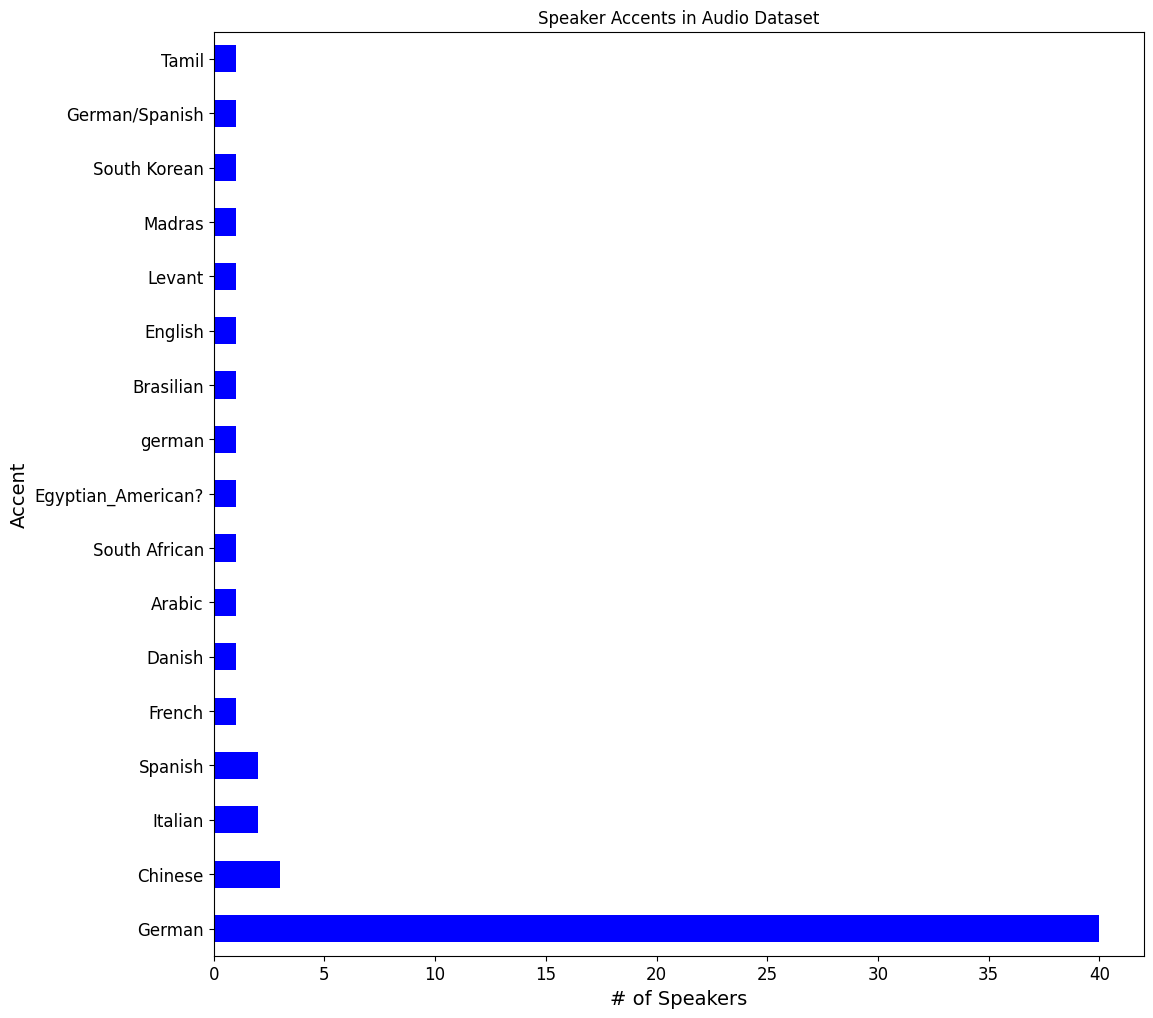

In [33]:
accent_data = trans_metadata["accent"]
plt.figure(figsize=(12,12))
accent_data.value_counts().plot.barh(color="blue")
plt.title("Speaker Accents in Audio Dataset")
plt.ylabel("Accent")
plt.xlabel("# of Speakers")
# save_fig("Label Distribution")
plt.show()

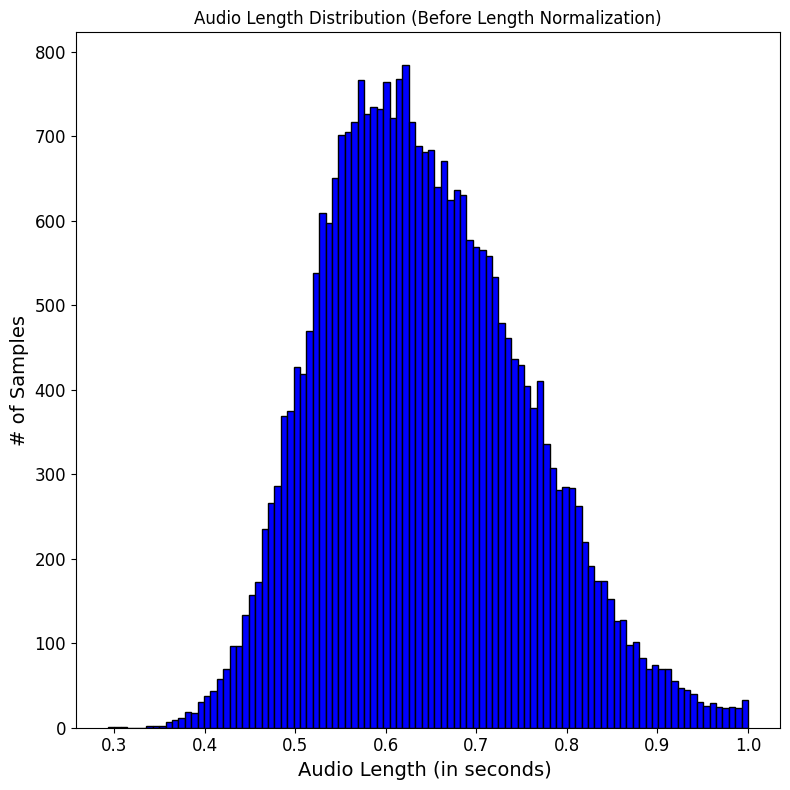

In [8]:
sample_len = [len(x)/SR for x in audios]
plt.figure(figsize=(8,8))
# time_values = np.linspace(0, np.max(sample_len)/SR, len(sample_len))
plt.hist(sample_len,color="b",bins=100,edgecolor='black')
plt.title("Audio Length Distribution (Before Length Normalization)")
plt.xlabel("Audio Length (in seconds) ")
plt.ylabel("# of Samples")
# save_fig("Sample distribution")
plt.tight_layout()
plt.show()

In [11]:
sample_data = []
sample_labels = []
counter = np.random.randint(len(labels)-1500)
while True:
    if((len(sample_labels) not in labels) and (labels[counter] not in sample_labels)):
        sample_data.append(audios[counter]) 
        sample_labels.append(labels[counter])
        counter+=1
    counter+=1
    if(len(sample_labels)==10):
        break

In [18]:
sample_labels[0]

'9'

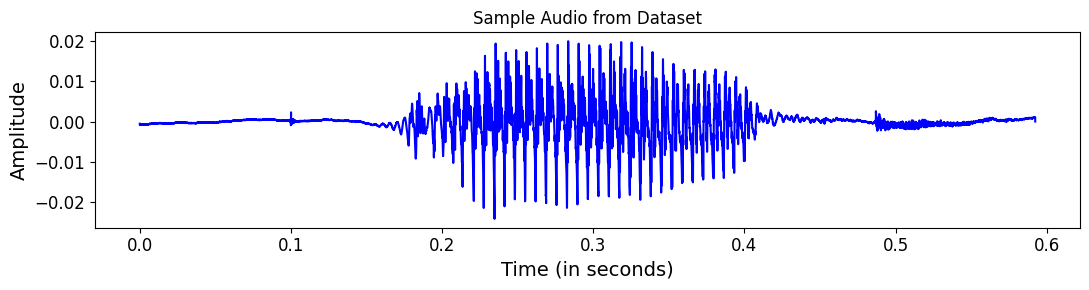

In [51]:
plt.figure(figsize=(11,3))
time_values = np.linspace(0, len(sample_data[4])/SR, len(sample_data[4]))
        
plt.plot(time_values,sample_data[4],color="b")
plt.title("Sample Audio from Dataset")
plt.xlabel("Time (in seconds)")
plt.ylabel("Amplitude")
plt.tight_layout()
# plt.xticks([])  # Hide x ticks
# plt.yticks([])
plt.show()

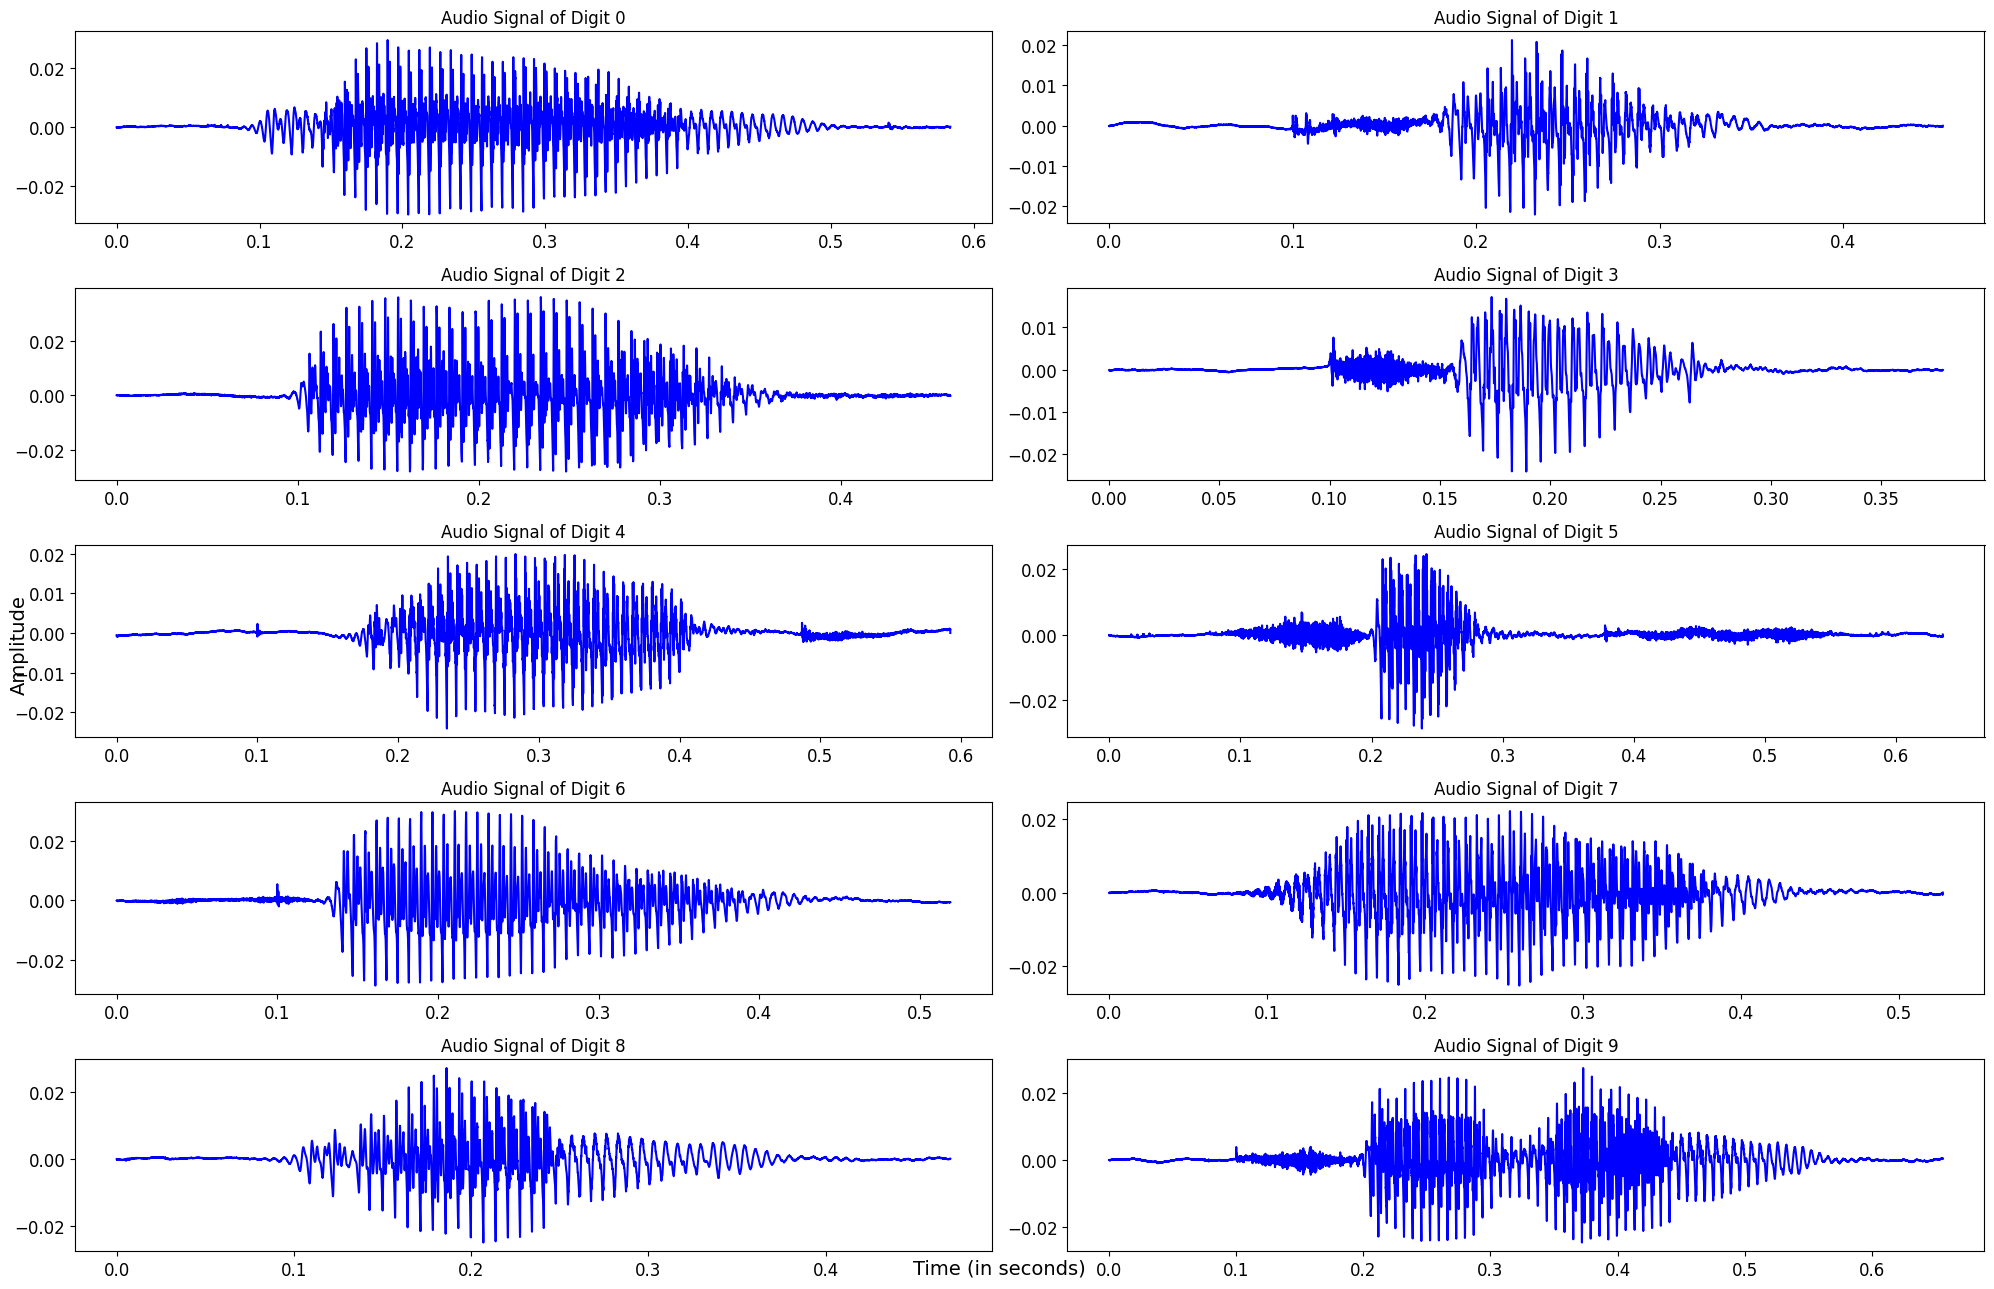

In [10]:
fig, axs = plt.subplots(5, 2,figsize=(20, 13))
sample_count = 0    
for i in range(5):
    for j in range(2):
        time_values = np.linspace(0, len(sample_data[sample_count])/SR, len(sample_data[sample_count]))
        axs[i, j].plot(time_values,sample_data[sample_count],color="b")
        axs[i, j].set_title(f'Audio Signal of Digit {sample_count}')
        sample_count+=1
 
fig.text(0.5, 0.02, 'Time (in seconds)', ha='center', va='center', fontsize=14)  # X label
fig.text(0.01, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical', fontsize=14)  # Y label

plt.tight_layout()
plt.show()

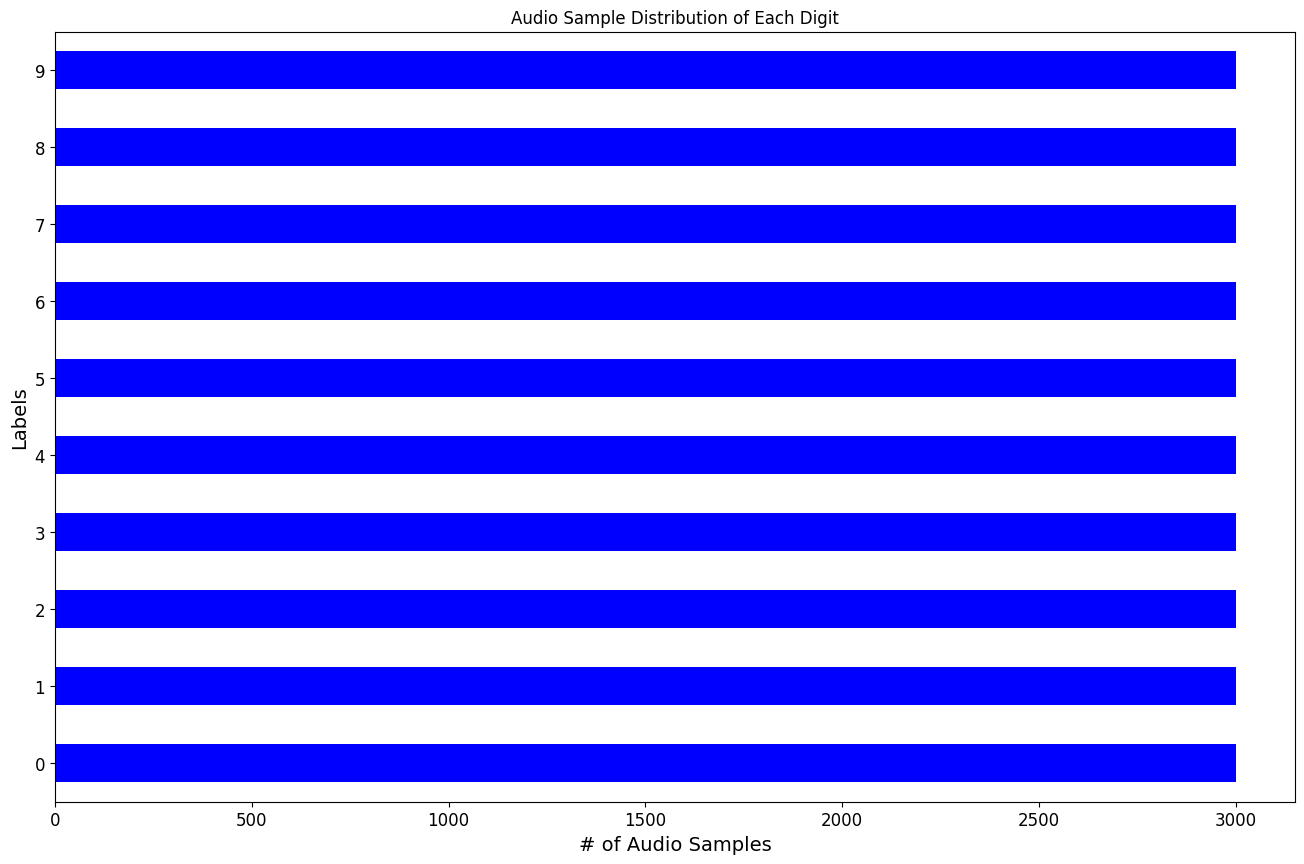

In [22]:
labels.sort()
data_label = pd.Series(labels)
plt.figure(figsize=(16,10))
# plt.figure(figsize=(13,4))
plt.title("Audio Sample Distribution of Each Digit")
data_label.value_counts().plot.barh(color="blue")
plt.ylabel("Labels")
plt.xlabel("# of Audio Samples")
# save_fig("Label Distribution")
plt.show()

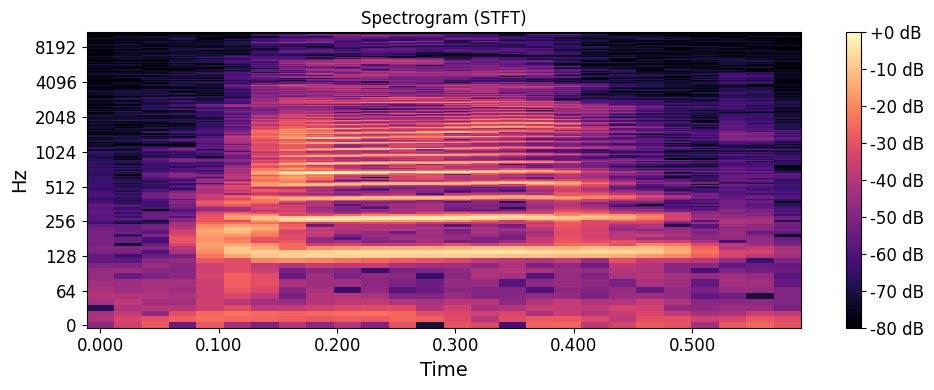

In [13]:
stft = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data[0])), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(stft, sr=SR, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.tight_layout()
plt.show()

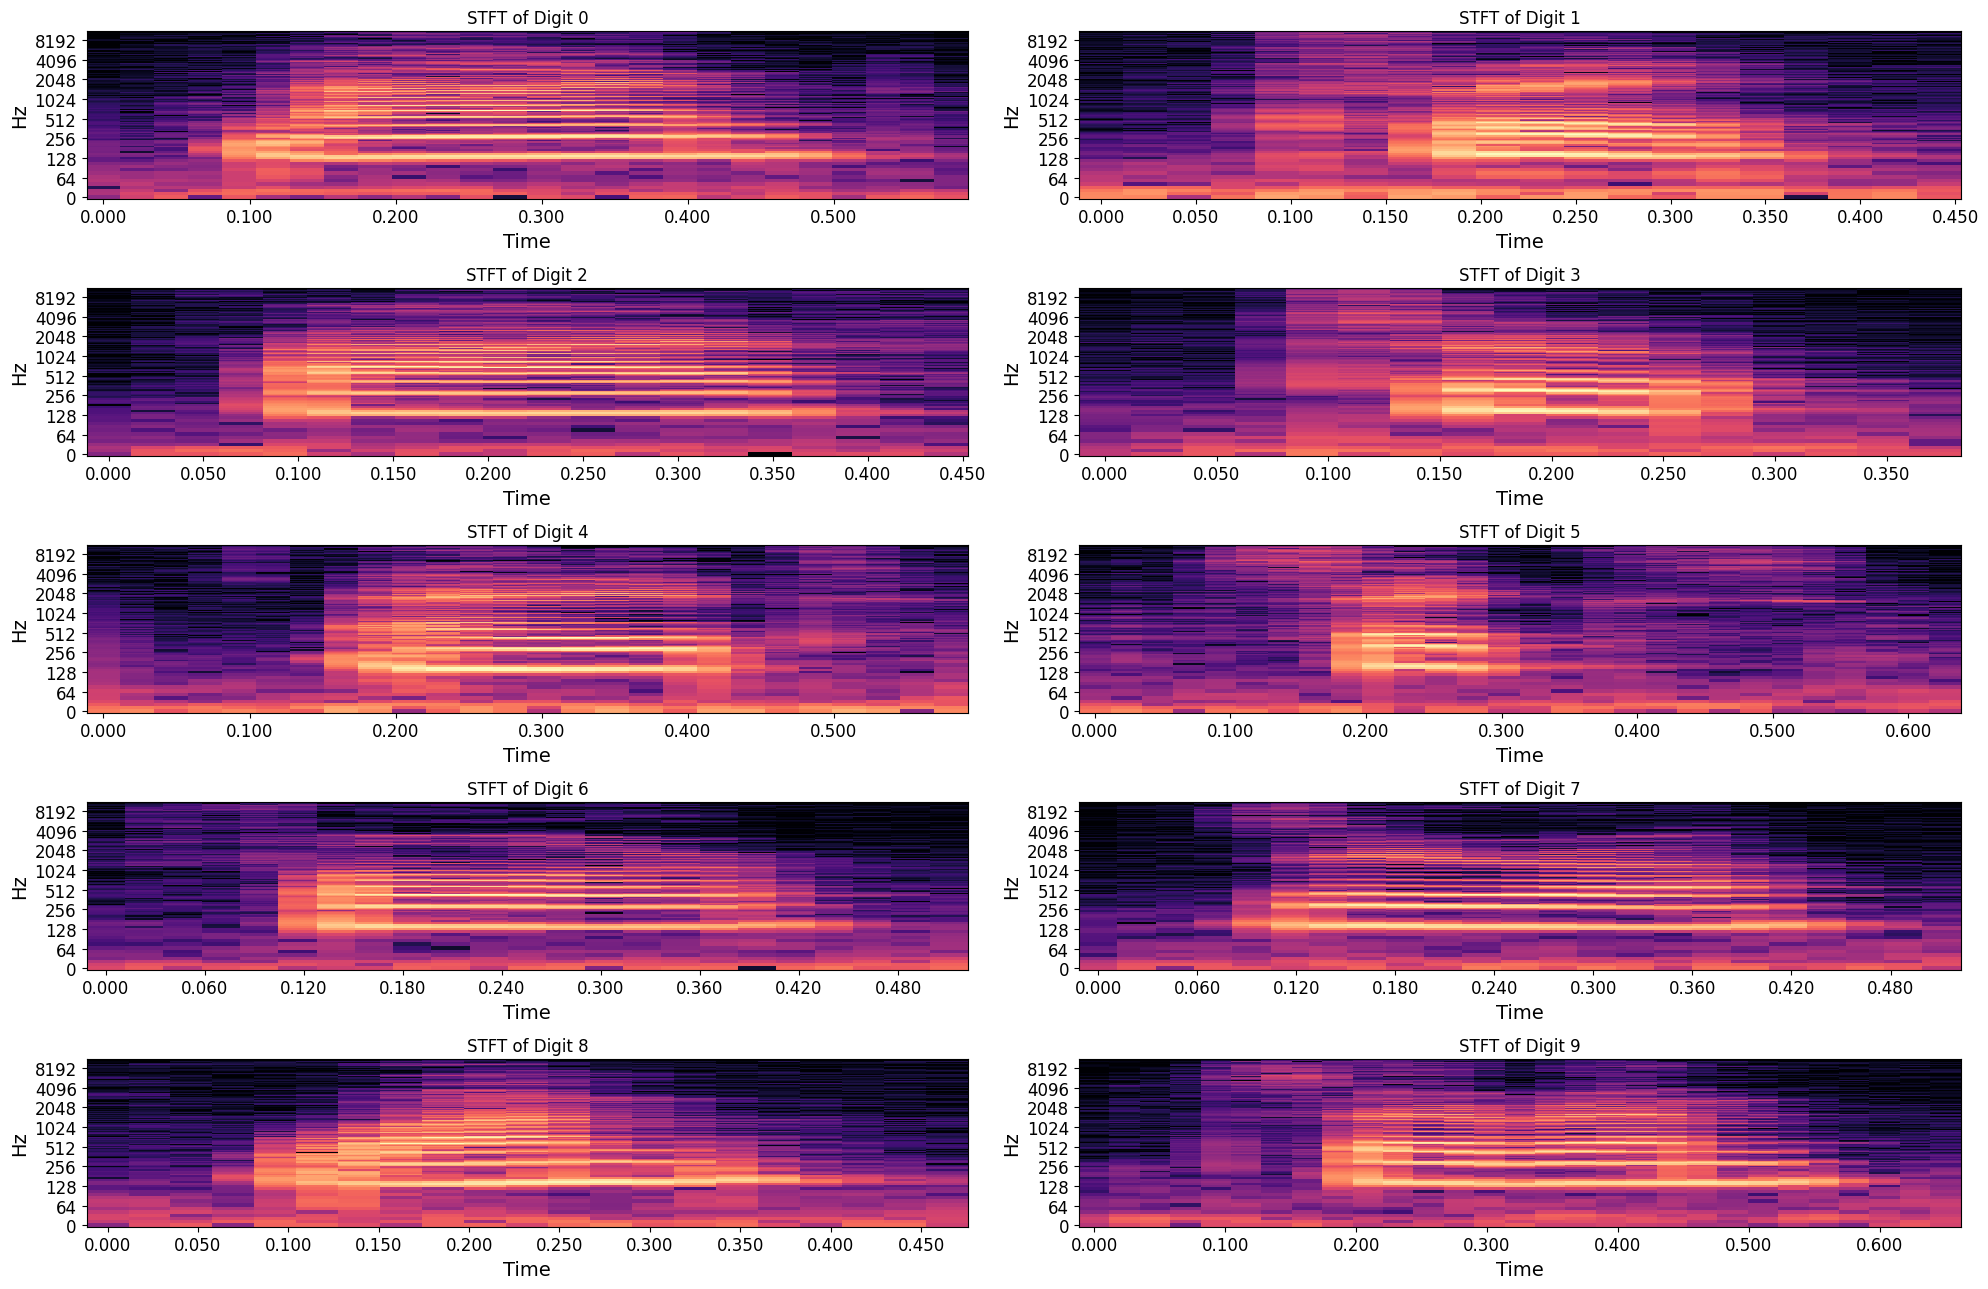

In [14]:
fig, axs = plt.subplots(5, 2,figsize=(20, 13))
sample_count = 0    
for i in range(5):
    for j in range(2):
        stft = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data[sample_count])), ref=np.max)
        # axs[i, j].plot(time_values,sample_data[sample_count],color="b")
        axs[i, j].set_title(f'STFT of Digit {sample_count}')
        librosa.display.specshow(stft, sr=SR, x_axis='time', y_axis='log',ax=axs[i, j])
        sample_count+=1
 
plt.tight_layout()
plt.show()

## Data Preprocessing

### Normalize Data Lengths

In [11]:
19185/22050

0.8700680272108844

In [47]:
sample_len = [len(x) for x in audios]
print("1st Percentile: ",np.percentile(sample_len,1))
print("3rd Percentile: ",np.percentile(sample_len,3))
print("5th Percentile: ",np.percentile(sample_len,50))
print("10th Percentile: ",np.percentile(sample_len,10))
print("95th Percentile: ",np.percentile(sample_len,95))
print("97th Percentile: ",np.percentile(sample_len,99))

1st Percentile:  9391.94
3rd Percentile:  10150.0
5th Percentile:  13936.0
10th Percentile:  11168.0
95th Percentile:  18502.0
97th Percentile:  20485.01


In [10]:
min_percentile = int(np.percentile(sample_len,3))
max_percentile = int(np.percentile(sample_len,97))
LENGTH = int(0.8 * SR)
print(LENGTH)
print(min_percentile)
print(max_percentile)

17640
10150
19185


In [11]:
audios, SR, labels = fetch_data(length=LENGTH,min=min_percentile,max=max_percentile)
audios = np.array(audios)
labels = np.array(labels)

Reading Data ... : 100%|██████████| 30000/30000 [00:32<00:00, 923.53it/s] 


In [12]:
print("Sampling Rate: ",SR)
# print("Labels: ",labels[:5])
print("Total Audio Files: ",len(audios))
print("Total Labels: ",len(labels))

Sampling Rate:  22050
Total Audio Files:  28198
Total Labels:  28198


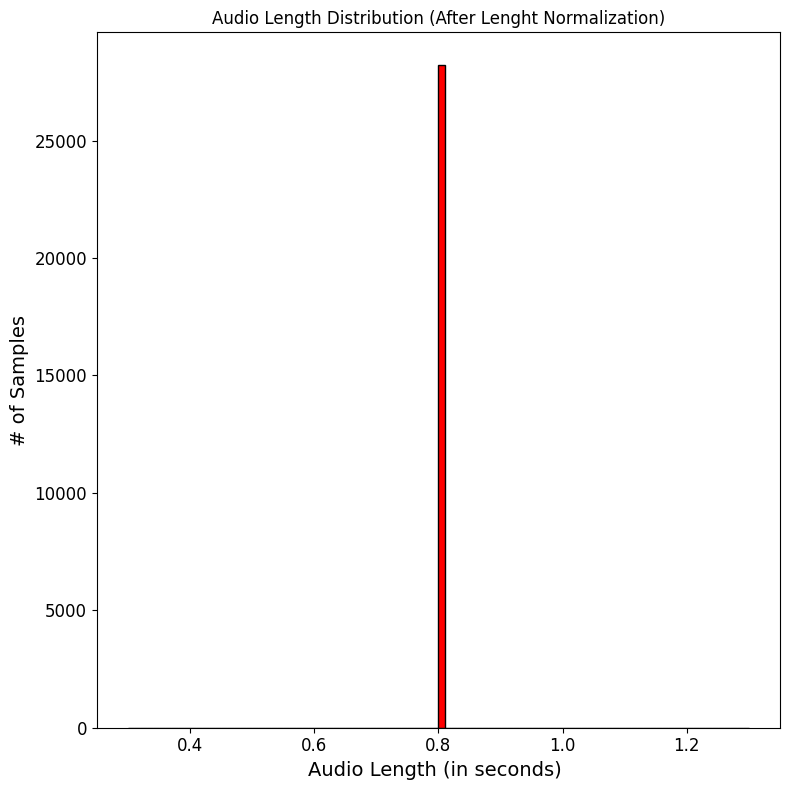

In [13]:
sample_len = [len(x)/SR for x in audios]
# time_values = np.linspace(0, np.max(sample_len)/SR, len(sample_len))
plt.figure(figsize=(8,8))
plt.hist(sample_len,color="r",bins=100,edgecolor='black')
plt.title("Audio Length Distribution (After Lenght Normalization)")
plt.xlabel("Audio Length (in seconds) ")
plt.ylabel("# of Samples")
# save_fig("Sample distribution")
plt.tight_layout()
plt.show()

In [14]:
sample_data = []
sample_labels = []
counter = np.random.randint(len(labels)-1500)
while True:
    if((len(sample_labels) not in labels) and (labels[counter] not in sample_labels)):
        sample_data.append(audios[counter]) 
        sample_labels.append(labels[counter])
        counter+=1
    counter+=1
    if(len(sample_labels)==10):
        break

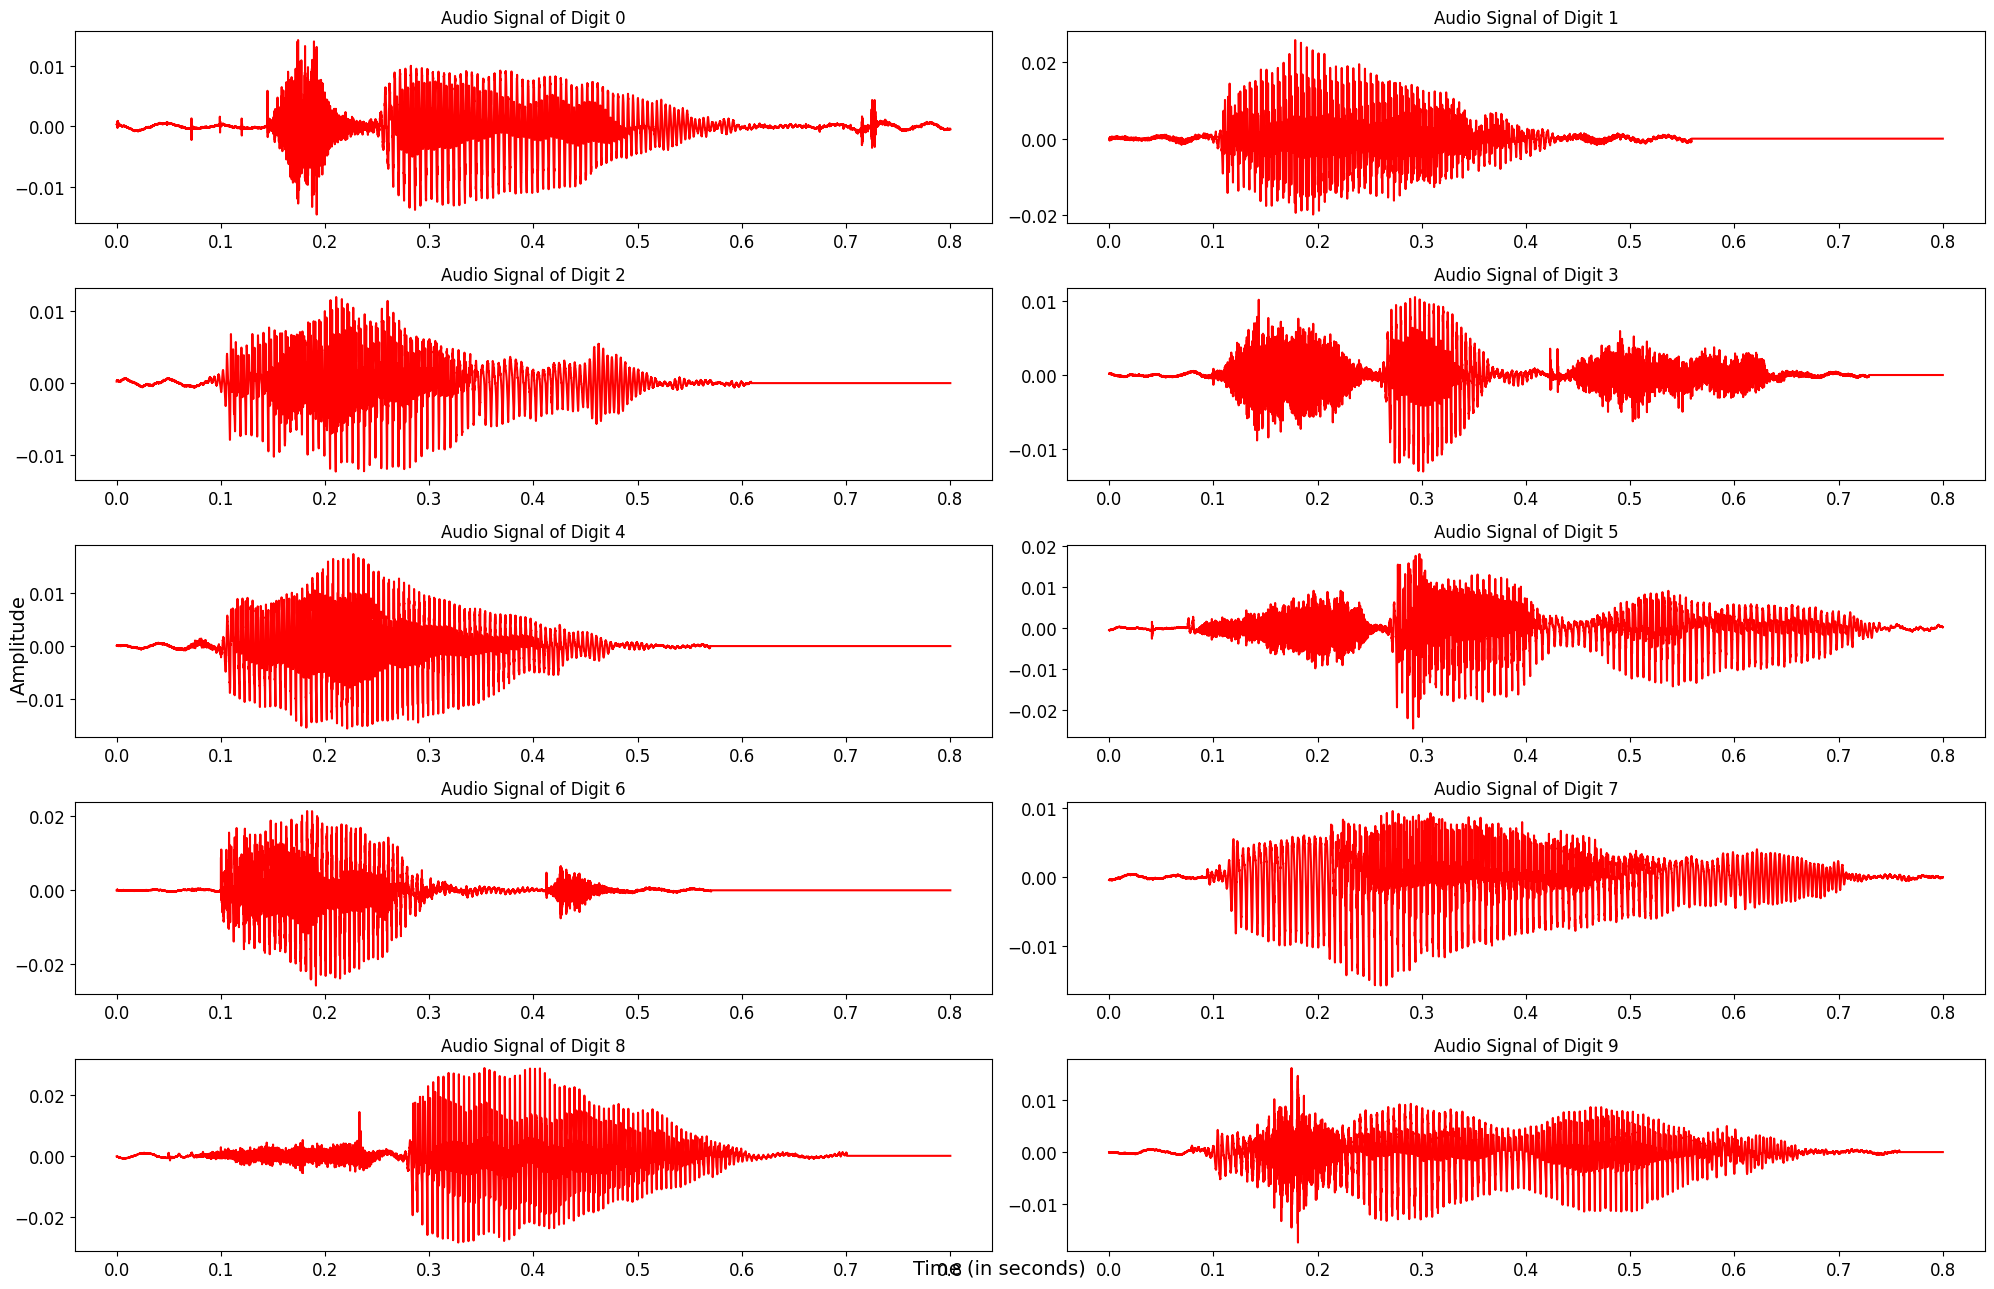

In [15]:
fig, axs = plt.subplots(5, 2,figsize=(20, 13))
sample_count = 0    
for i in range(5):
    for j in range(2):
        time_values = np.linspace(0, len(sample_data[sample_count])/SR, len(sample_data[sample_count]))
        axs[i, j].plot(time_values,sample_data[sample_count],color="r")
        axs[i, j].set_title(f'Audio Signal of Digit {sample_count}')
        sample_count+=1
 
fig.text(0.5, 0.02, 'Time (in seconds)', ha='center', va='center', fontsize=14)  # X label
fig.text(0.01, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical', fontsize=14)  # Y label

plt.tight_layout()
plt.show()

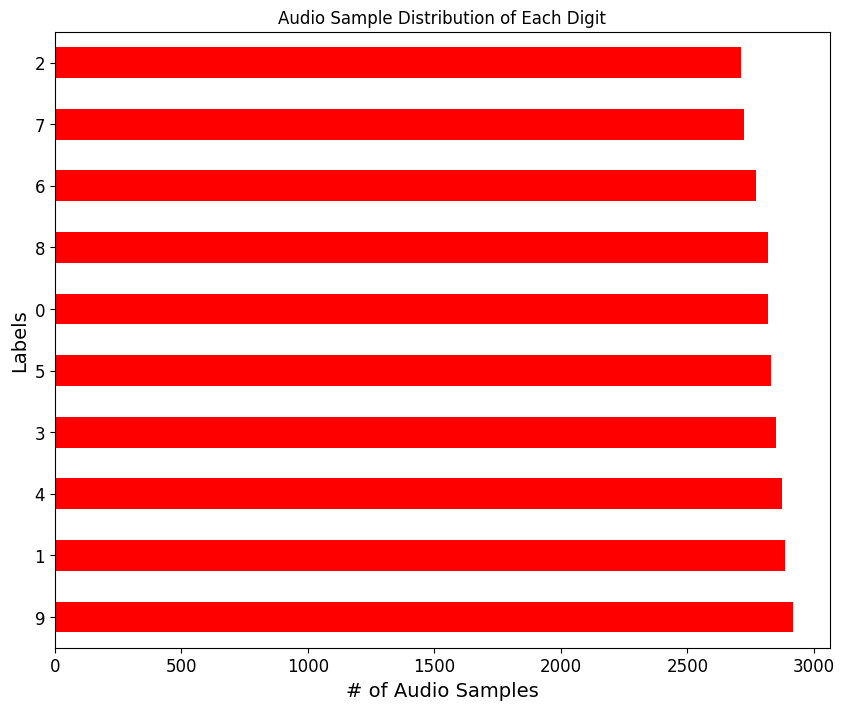

In [16]:
temp_labels = labels

temp_labels.sort()
data_label = pd.Series(temp_labels)
plt.figure(figsize=(10,8))
plt.title("Audio Sample Distribution of Each Digit")
data_label.value_counts().plot.barh(color="red")
plt.ylabel("Labels")
plt.xlabel("# of Audio Samples")
# save_fig("Label Distribution")
plt.show()

# plt.figure(figsize=(10,8))
# plt.title("Audio Sample Distribution of Each Digit")
# data_label.value_counts().plot.barh(color="blue")
# plt.ylabel("Labels")
# plt.xlabel("# of Audio Samples")
# # save_fig("Label Distribution")
# plt.show()

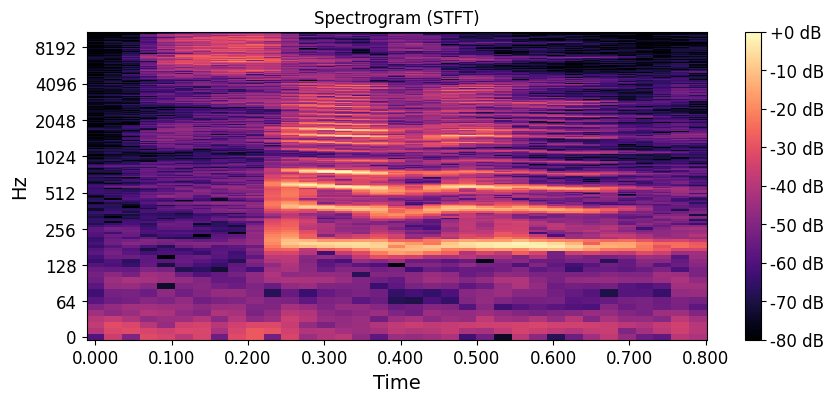

In [17]:
stft = librosa.amplitude_to_db(np.abs(librosa.stft(audios[0])), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(stft, sr=SR, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.show()


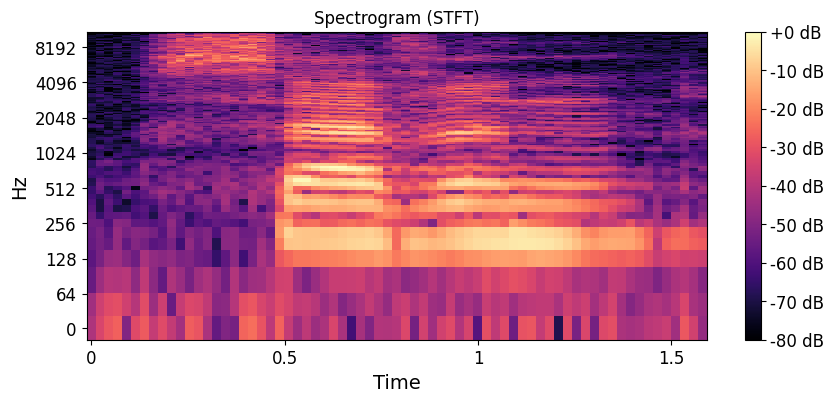

In [18]:
stft = librosa.amplitude_to_db(np.abs(librosa.stft(audios[0],n_fft=512,hop_length=256)),ref = np.max)
# stft = librosa.amplitude_to_db(np.abs(librosa.stft(audios[0])), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(stft, sr=SR, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.show()

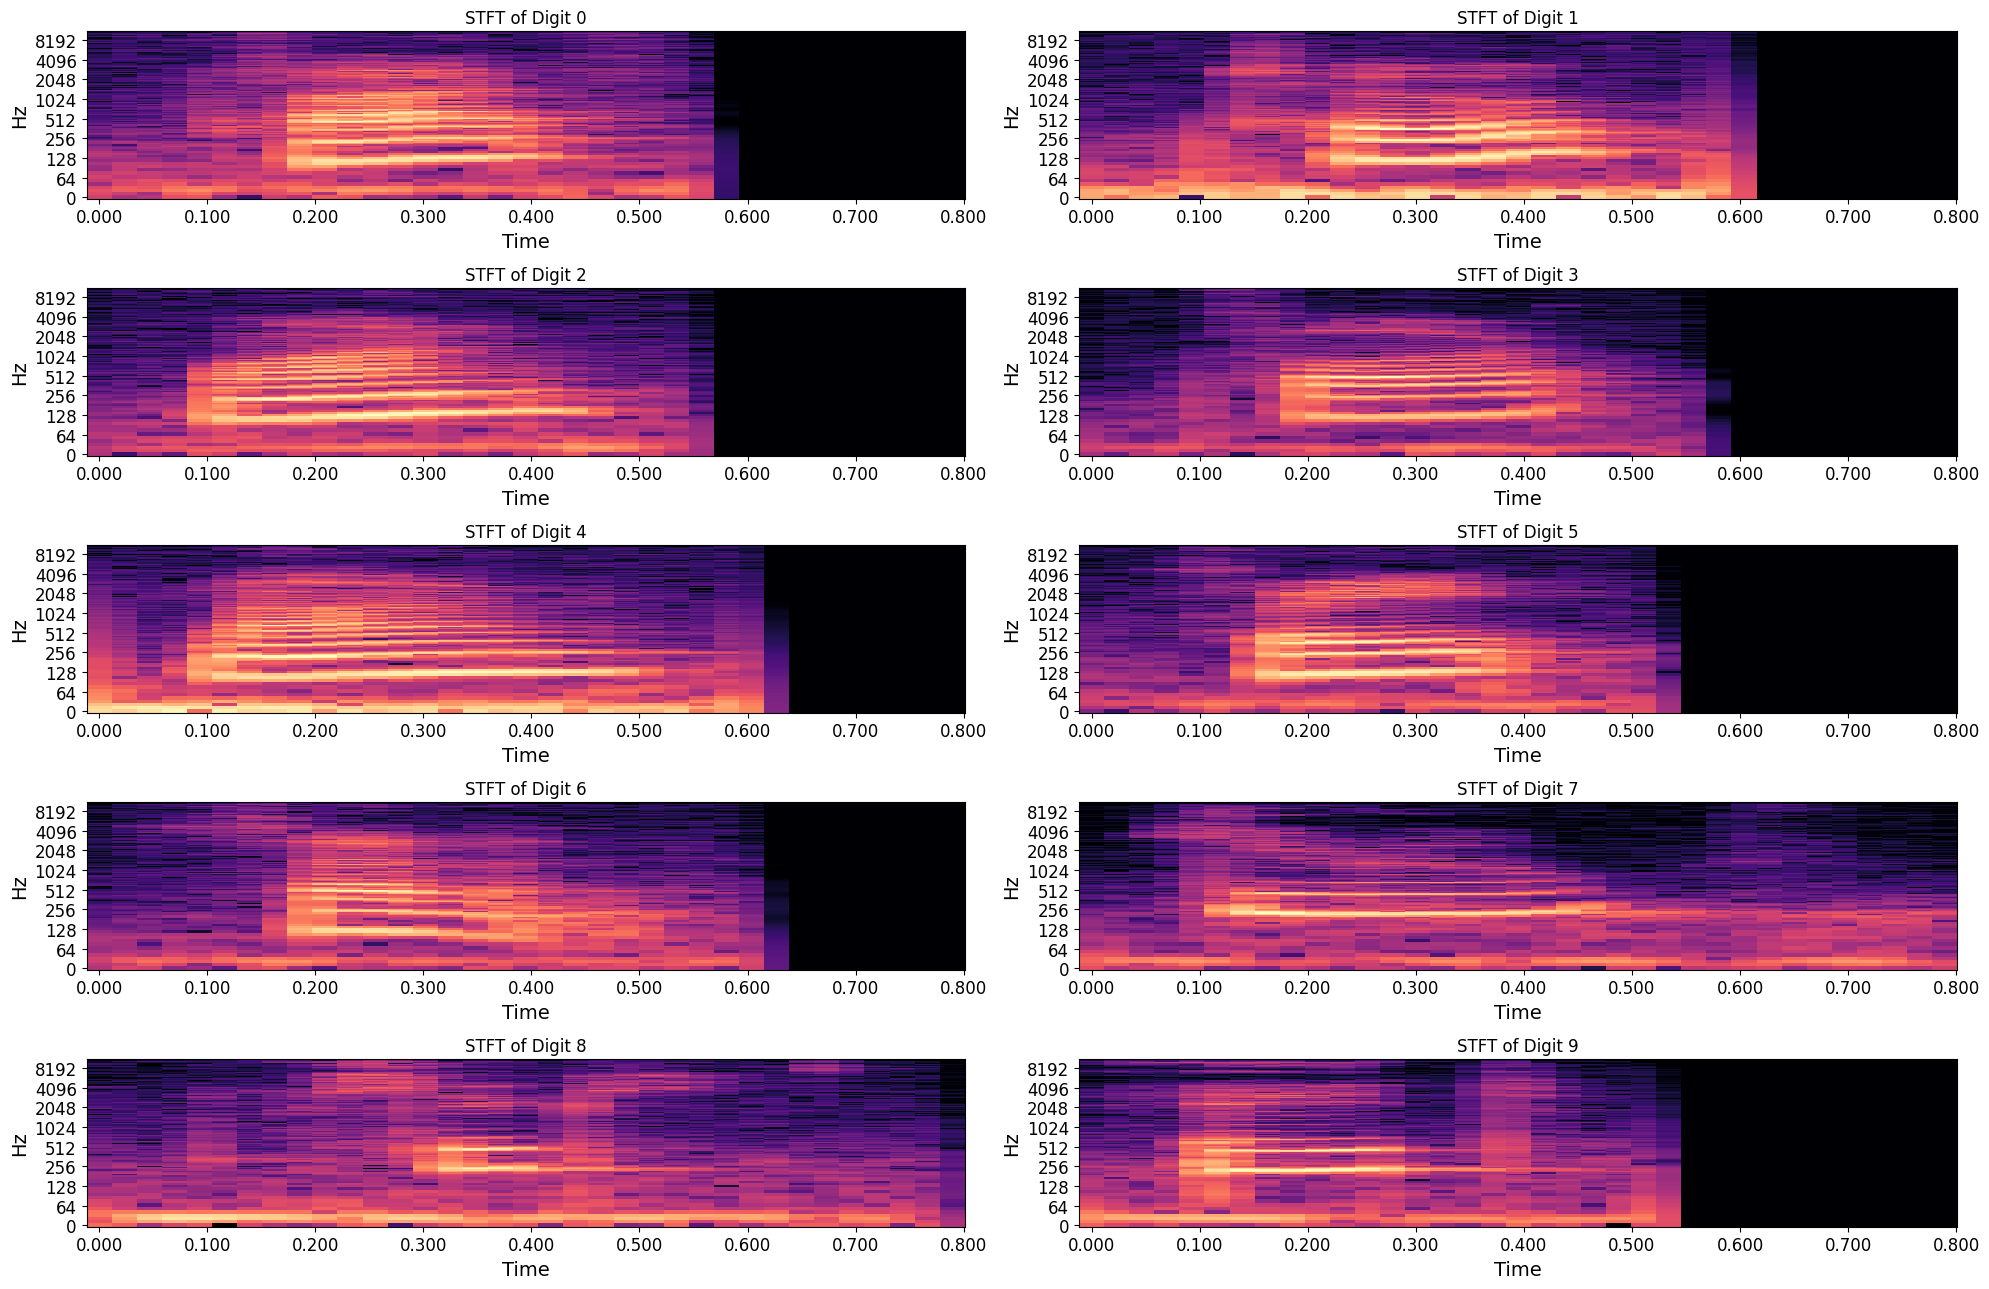

In [25]:
fig, axs = plt.subplots(5, 2,figsize=(20, 13))
sample_count = 0    
for i in range(5):
    for j in range(2):
        stft = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data[sample_count])), ref=np.max)
        # axs[i, j].plot(time_values,sample_data[sample_count],color="b")
        axs[i, j].set_title(f'STFT of Digit {sample_count}')
        librosa.display.specshow(stft, sr=SR, x_axis='time', y_axis='log',ax=axs[i, j])
        sample_count+=1
 
plt.tight_layout()
plt.show()

## Train test split

In [26]:
# Perform an initial split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.1, random_state=42, stratify=labels)

# Perform an second split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print("Shape of training data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)
print("Shape of validation data: ", X_val.shape)

Shape of training data:  (22840, 17640)
Shape of test data:  (2820, 17640)
Shape of validation data:  (2538, 17640)


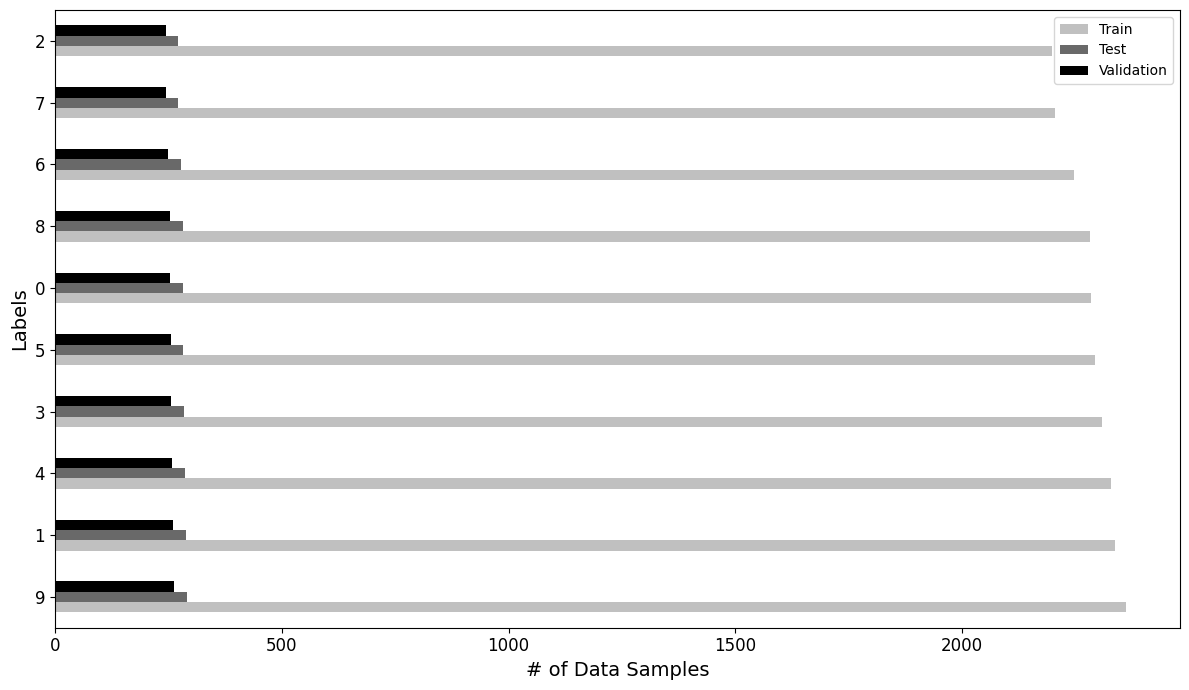

In [27]:
label_dataframe = pd.DataFrame({"Train": pd.Series(y_train).value_counts(),
                                "Test" :pd.Series(y_test).value_counts(),
                                "Validation" : pd.Series(y_val).value_counts()
                                })

label_dataframe.plot(kind='barh',rot=0,color={"black","dimgray","silver"},figsize=(12,7))
plt.xlabel("# of Data Samples")
plt.ylabel("Labels")
plt.tight_layout()
plt.show()


In [28]:
# save train test and validation data locally in folder for repeated use

with open(r"X_train.pkl","wb") as file:
    pickle.dump(X_train,file)
    
with open(r"X_test.pkl","wb") as file:
    pickle.dump(X_test,file)
    
with open(r"X_val.pkl","wb") as file:
    pickle.dump(X_val,file)

with open(r"y_train.pkl","wb") as file:
    pickle.dump(y_train,file)
    
with open(r"y_test.pkl","wb") as file:
    pickle.dump(y_test,file)
    
with open(r"y_val.pkl","wb") as file:
    pickle.dump(y_val,file)

In [ ]:
with open(r"X_train.pkl","rb") as file:
    X_train = pickle.load(file)
    
with open(r"X_test.pkl","rb") as file:
    X_test = pickle.load(file)
    
with open(r"X_val.pkl","rb") as file:
    X_val = pickle.load(file)

with open(r"y_train.pkl","rb") as file:
    y_train = pickle.load(file)

with open(r"y_test.pkl","rb") as file:
    y_test = pickle.load(file)

with open(r"y_val.pkl","rb") as file:
    y_val = pickle.load(file)

## Feature Extraction

In [43]:
def extract_stft(audios):
    stft_features = []
    for audio in tqdm.tqdm(audios,desc="Extracting Features ... "):
        stft = librosa.amplitude_to_db(np.abs(librosa.stft(audio,n_fft=512,hop_length=256)), ref=np.max)
        stft  = stft.reshape((*stft.shape, 1))  # Add channel dimension
        
        stft_features.append(stft)
    return np.array(stft_features)

In [44]:
X_train_features = extract_stft(X_train)
X_test_features = extract_stft(X_test)
X_val_features = extract_stft(X_val)

Extracting Features ... : 100%|██████████| 2538/2538 [00:02<00:00, 1167.23it/s]


In [73]:
# save train test and validation data locally in folder for repeated use
import pickle
with open(r"X_train_features.pkl","wb") as file:
    pickle.dump(X_train_features,file)
    
with open(r"X_test_features.pkl","wb") as file:
    pickle.dump(X_test_features,file)
    
with open(r"X_val_features.pkl","wb") as file:
    pickle.dump(X_val_features,file)

with open(r"y_train.pkl","wb") as file:
    pickle.dump(y_train,file)
    
with open(r"y_test.pkl","wb") as file:
    pickle.dump(y_test,file)
    
with open(r"y_val.pkl","wb") as file:
    pickle.dump(y_val,file)

In [74]:
with open(r"X_train_features.pkl","rb") as file:
    X_train_features = pickle.load(file)
    
with open(r"X_test_features.pkl","rb") as file:
    X_test_features = pickle.load(file)
    
with open(r"X_val_features.pkl","rb") as file:
    X_val_features = pickle.load(file)

with open(r"y_train.pkl","rb") as file:
    y_train = pickle.load(file)

with open(r"y_test.pkl","rb") as file:
    y_test = pickle.load(file)

with open(r"y_val.pkl","rb") as file:
    y_val = pickle.load(file)

## Variational AutoEncoder Model

In [60]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [62]:
# Define the Convolutional VAE architecture
input_shape = (257,69,1)
latent_dim = 2  # Size of the latent space

In [63]:
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [64]:
def sampling(args):
    z_mean, z_log_var = args
    # return the z mean
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [65]:
z = Lambda(sampling)([z_mean, z_log_var])

In [66]:
encoder = Model(inputs, z)
encoder.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 257, 69, 1)]         0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 257, 69, 32)          320       ['input_1[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 257, 69, 64)          18496     ['conv2d_4[0][0]']            
                                                                                                  
 flatten_2 (Flatten)         (None, 1134912)              0         ['conv2d_5[0][0]']            
                                                                                            

In [67]:
decoder_input = Input(shape=(latent_dim,))
y = Dense(257 * 69 * 64, activation='relu')(decoder_input)
y = Reshape((257, 69, 64))(y)
# y = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(y)

In [68]:
decoder_output = y
decoder = Model(decoder_input,y)

decoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_12 (Dense)            (None, 1134912)           3404736   
                                                                 
 reshape_3 (Reshape)         (None, 257, 69, 64)       0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 257, 69, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 257, 69, 1)        289       
 Transpose)                                                      
                                                                 
Total params: 3423489 (13.06 MB)
Trainable params: 3423489 

In [69]:
outputs = decoder(encoder(inputs))

In [70]:
# Define the loss function for VAE
def vae_loss(inputs, outputs):
    xent_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=(1, 2, 3))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [71]:
cnn_vae = Model(inputs, outputs)
cnn_vae.compile(optimizer='adam', loss=vae_loss)
cnn_vae.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 69, 1)]      0         
                                                                 
 model_8 (Functional)        (None, 2)                 290557572 
                                                                 
 model_9 (Functional)        (None, 257, 69, 1)        3423489   
                                                                 
Total params: 293981061 (1.10 GB)
Trainable params: 293981061 (1.10 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
# Train the VAE
cnn_vae_history = cnn_vae.fit(X_train_features, X_train_features, epochs=2, batch_size=128, shuffle=True, validation_data=(X_val_features, X_val_features))

Train on 22840 samples, validate on 2538 samples
Epoch 1/2


2023-11-15 10:55:41.920176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-15 10:55:41.951511: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/conv2d_transpose_6/kernel/v/Assign' id:824 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_transpose_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d_transpose_6/kernel/v, training/Adam/conv2d_transpose_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


22840/22840 [==============================] - ETA: 0s - loss: nan

/Users/rabinnepal/miniforge3/envs/nn_project_env/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-15 11:08:59.294273: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:386 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/model_9_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


22840/22840 [==============================] - 824s 36ms/sample - loss: nan - val_loss: nan
Epoch 2/2
 6400/22840 [=======>......................] - ETA: 11:05 - loss: nan

KeyboardInterrupt: 

## Performance Measurements

### Train Validation Test Loss/Accuracy

### Distribution Map

### Topography Map

### k-fold Cross Validation